# Active contour model

In [1]:
from skimage.segmentation import active_contour, find_boundaries, flood_fill
from scipy.ndimage import *
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [36]:
def ac_mask(mask_path, image_path):
    '''
    This function applied an active contour model to the segmentation mask.
    It outputs a segmentation mask with 3 classes.
    mask_path: datapath to the mask
    image_path: datapath to the image corresponding to the mask
    '''
    mask = Image.open(mask_path).convert('L')
    mask = np.array(mask, dtype=np.uint8)

    img = Image.open(image_path).convert('L')
    img = np.array(img, dtype=np.uint8)
    
    nx, ny = mask.shape
    
    # Find boundaries of each mask
    init = mask*find_boundaries(mask, mode='inner')
    init_1 = init*(init == 1)
    init_2 = init*(init == 2)
    init_3 = init*(init == 3)
    
    # Mask 1
    # Find coordinates of boundary
    indeces1 = np.where(init_1 == 1)
    xy_coords1 = np.column_stack(indeces1)
    
    # Apply AC
    snake1 = active_contour(img,
                       xy_coords1, alpha=0.015, beta=10, gamma=0.000001, w_line=-1)
    
    new_mask1 = np.zeros((nx, ny))
    
    # Build new boundary from snake coordinates
    for i, j in snake1:
        new_mask1[int(i), int(j)] = 1
    
    # Fill the mask
    new_mask1 = binary_fill_holes(new_mask1)
    
    # Mask 2
    # Find coordinates of boundary
    indeces2 = np.where(init_2 == 2)
    xy_coords2 = np.column_stack(indeces2)
    
    # Apply AC
    snake2 = active_contour(img,
                       xy_coords2, alpha=0.015, beta=10, gamma=0.000001, w_line=-1)
    
    new_mask2 = np.zeros((nx, ny))
    
    # Build new boundary from snake coordinates
    for i, j in snake2:
        new_mask2[int(i), int(j)] = 1
    
    # Fill the mask
    new_mask2 = binary_closing(new_mask2, structure=np.ones((10,10)))
    
    # Set to right class
    new_mask2 = new_mask2*2
    
    # Mask 3
    # Find coordinates of boundary
    indeces3 = np.where(init_3 == 3)
    xy_coords3 = np.column_stack(indeces3)
    
    # Apply AC
    snake3 = active_contour(img,
                       xy_coords3, alpha=0.015, beta=10, gamma=0.0000001, w_line=-1)
    
    new_mask3 = np.zeros((nx, ny))
    
    # Build new boundary from snake coordinates
    for i, j in snake3:
        new_mask3[int(i), int(j)] = 1

    # Fill the mask
    new_mask3 = binary_fill_holes(new_mask3)
    
    # Set to right class
    new_mask3 = new_mask3*3
    
    # Combine mask 1 and 2
    new_mask = new_mask1+new_mask2
    
    # If they overlap, choose mask 2
    new_mask[new_mask == 3] = 2
    
    # Add mask 3
    new_mask = new_mask+new_mask3
    
    # If they overlap, choose mask 3
    new_mask[new_mask > 3] = 3
    
    return new_mask

Text(0.5, 1.0, 'Mask with AC')

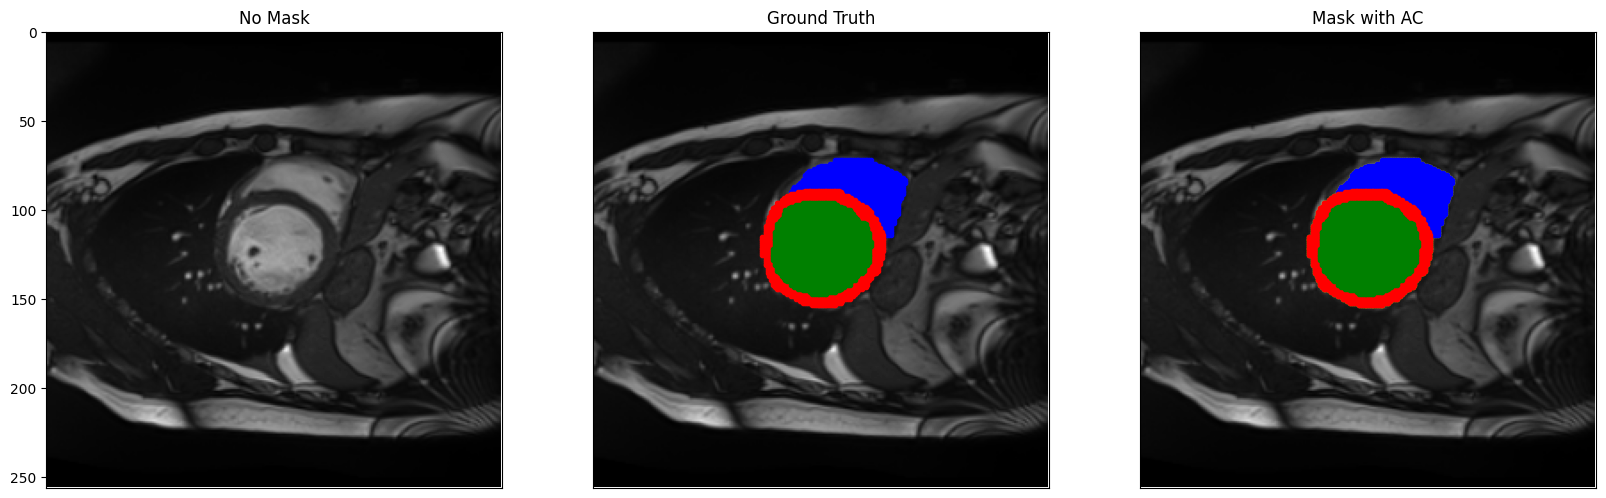

In [39]:
mask_path = 'preprocessed/training/patient001/patient001_frame01_slice3_ED_24.414062_gt.png'
img_path = 'preprocessed/training/patient001/patient001_frame01_slice3_ED_24.414062.png'
img = Image.open(img_path).convert('L')
img = np.array(img, dtype=np.uint8)

mask = Image.open(mask_path).convert('L')
mask = np.array(mask, dtype=np.uint8)

# New mask
new_mask = ac_mask(mask_path, img_path)
indeces1 = np.where(new_mask == 1)
coords1 = np.column_stack(indeces1)

indeces2 = np.where(new_mask == 2)
coords2 = np.column_stack(indeces2)

indeces3 = np.where(new_mask == 3)
coords3 = np.column_stack(indeces3)

# GT
indeces4 = np.where(new_mask == 1)
coords4 = np.column_stack(indeces4)

indeces5 = np.where(new_mask == 2)
coords5 = np.column_stack(indeces5)

indeces6 = np.where(new_mask == 3)
coords6 = np.column_stack(indeces6)

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20, 20))

ax0.imshow(img, cmap=plt.cm.gray)
ax0.set_xticks([]), ax1.set_yticks([])
ax0.axis([0, img.shape[1], img.shape[0], 0])
ax0.set_title('No Mask')

ax1.imshow(img, cmap=plt.cm.gray)
ax1.plot(coords4[:, 1], coords4[:, 0], '.b')
ax1.plot(coords5[:, 1], coords5[:, 0], '.r')
ax1.plot(coords6[:, 1], coords6[:, 0], '.g')
ax1.set_xticks([]), ax1.set_yticks([])
ax1.axis([0, img.shape[1], img.shape[0], 0])
ax1.set_title('Mask')

ax2.imshow(img, cmap=plt.cm.gray)
ax2.plot(coords4[:, 1], coords4[:, 0], '.y')
ax2.plot(coords5[:, 1], coords5[:, 0], '.y')
ax2.plot(coords6[:, 1], coords6[:, 0], '.y')
ax2.plot(coords1[:, 1], coords1[:, 0], '.b')
ax2.plot(coords2[:, 1], coords2[:, 0], '.r')
ax2.plot(coords3[:, 1], coords3[:, 0], '.g')
ax2.set_xticks([]), ax2.set_yticks([])
ax2.axis([0, img.shape[1], img.shape[0], 0])
ax2.set_title('Mask with AC')

## Worst mask

In [45]:
mask_path = 'worstbest/WorstSegmentation_seg.png'
img_path = 'worstbest/WorstSegmentation_img.png'
gt_path = 'worstbest/WorstSegmentation_mask.png'

img = Image.open(img_path).convert('L')
img = np.array(img, dtype=np.uint8)

mask = Image.open(mask_path).convert('L')
mask = np.array(mask, dtype=np.uint8)

gt = Image.open(gt_path).convert('L')
gt = np.array(gt, dtype=np.uint8)

new_mask = ac_mask(mask_path, img_path)

Text(0.5, 1.0, 'Worst mask with AC')

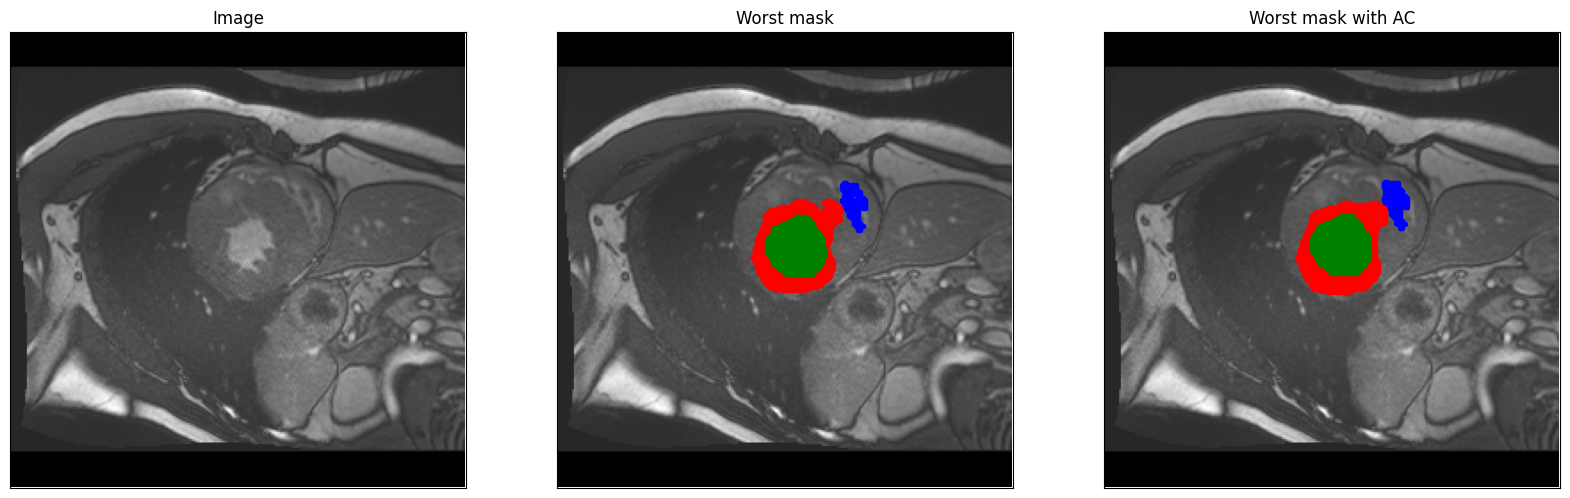

In [46]:
# new mask
indeces1 = np.where(new_mask == 1)
coords1 = np.column_stack(indeces1)

indeces2 = np.where(new_mask == 2)
coords2 = np.column_stack(indeces2)

indeces3 = np.where(new_mask == 3)
coords3 = np.column_stack(indeces3)

# worst mask
indeces4 = np.where(mask == 1)
coords4 = np.column_stack(indeces4)

indeces5 = np.where(mask == 2)
coords5 = np.column_stack(indeces5)

indeces6 = np.where(mask == 3)
coords6 = np.column_stack(indeces6)

# GT
indeces7 = np.where(gt == 1)
coords7 = np.column_stack(indeces7)

indeces8 = np.where(gt == 2)
coords8 = np.column_stack(indeces8)

indeces9 = np.where(gt == 3)
coords9 = np.column_stack(indeces9)

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20, 20))

ax0.imshow(img, cmap=plt.cm.gray)
ax1.plot(coords7[:, 1], coords7[:, 0], '.b')
ax1.plot(coords8[:, 1], coords8[:, 0], '.r')
ax1.plot(coords9[:, 1], coords9[:, 0], '.g')
ax0.set_xticks([]), ax0.set_yticks([])
ax0.axis([0, img.shape[1], img.shape[0], 0])
ax0.set_title('Image')

ax1.imshow(img, cmap=plt.cm.gray)
ax1.plot(coords4[:, 1], coords4[:, 0], '.b')
ax1.plot(coords5[:, 1], coords5[:, 0], '.r')
ax1.plot(coords6[:, 1], coords6[:, 0], '.g')
ax1.set_xticks([]), ax1.set_yticks([])
ax1.axis([0, img.shape[1], img.shape[0], 0])
ax1.set_title('Worst mask')

ax2.imshow(img, cmap=plt.cm.gray)
ax2.plot(coords1[:, 1], coords1[:, 0], '.b')
ax2.plot(coords2[:, 1], coords2[:, 0], '.r')
ax2.plot(coords3[:, 1], coords3[:, 0], '.g')
ax2.set_xticks([]), ax2.set_yticks([])
ax2.axis([0, img.shape[1], img.shape[0], 0])
ax2.set_title('Worst mask with AC')

## Best mask

In [47]:
mask_path = 'worstbest/BestSegmentation_seg.png'
img_path = 'worstbest/BestSegmentation_img.png'
gt_path = 'worstbest/BestSegmentation_mask.png'

img = Image.open(img_path).convert('L')
img = np.array(img, dtype=np.uint8)

mask = Image.open(mask_path).convert('L')
mask = np.array(mask, dtype=np.uint8)

gt = Image.open(gt_path).convert('L')
gt = np.array(gt, dtype=np.uint8)

new_mask = ac_mask(mask_path, img_path)

Text(0.5, 1.0, 'Best mask with AC')

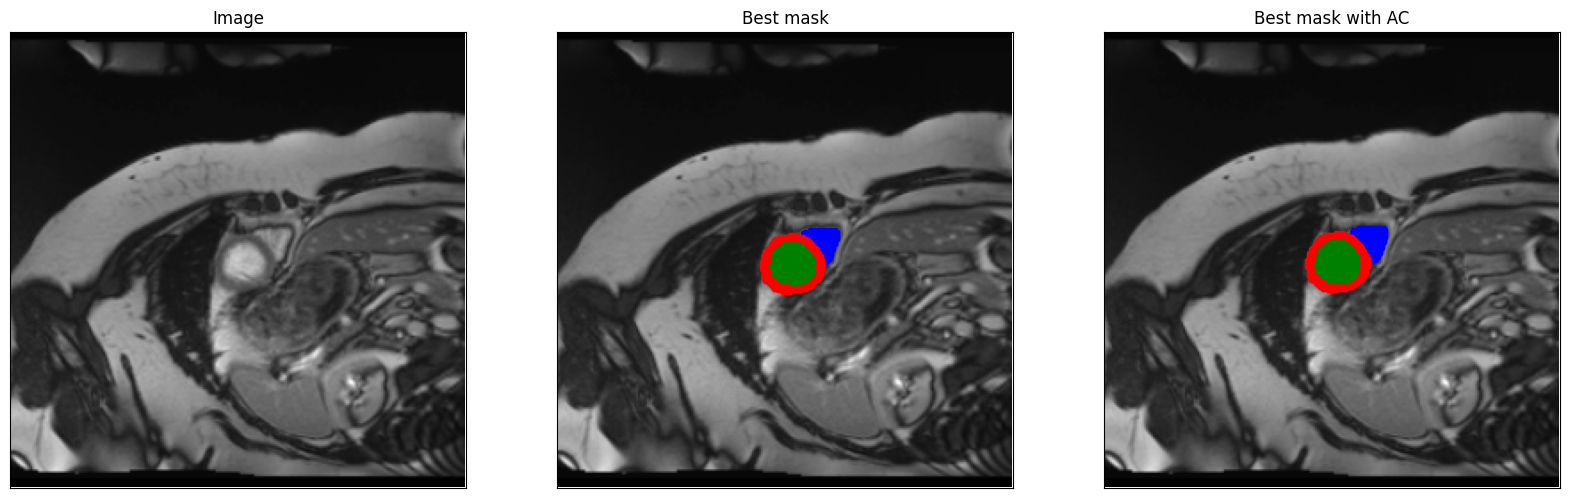

In [49]:
# new mask
indeces1 = np.where(new_mask == 1)
coords1 = np.column_stack(indeces1)

indeces2 = np.where(new_mask == 2)
coords2 = np.column_stack(indeces2)

indeces3 = np.where(new_mask == 3)
coords3 = np.column_stack(indeces3)

# best mask
indeces4 = np.where(mask == 1)
coords4 = np.column_stack(indeces4)

indeces5 = np.where(mask == 2)
coords5 = np.column_stack(indeces5)

indeces6 = np.where(mask == 3)
coords6 = np.column_stack(indeces6)

# GT
indeces7 = np.where(gt == 1)
coords7 = np.column_stack(indeces7)

indeces8 = np.where(gt == 2)
coords8 = np.column_stack(indeces8)

indeces9 = np.where(gt == 3)
coords9 = np.column_stack(indeces9)

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20, 20))

ax0.imshow(img, cmap=plt.cm.gray)
ax1.plot(coords7[:, 1], coords7[:, 0], '.b')
ax1.plot(coords8[:, 1], coords8[:, 0], '.r')
ax1.plot(coords9[:, 1], coords9[:, 0], '.g')
ax0.set_xticks([]), ax0.set_yticks([])
ax0.axis([0, img.shape[1], img.shape[0], 0])
ax0.set_title('Image')

ax1.imshow(img, cmap=plt.cm.gray)
ax1.plot(coords4[:, 1], coords4[:, 0], '.b')
ax1.plot(coords5[:, 1], coords5[:, 0], '.r')
ax1.plot(coords6[:, 1], coords6[:, 0], '.g')
ax1.set_xticks([]), ax1.set_yticks([])
ax1.axis([0, img.shape[1], img.shape[0], 0])
ax1.set_title('Best mask')

ax2.imshow(img, cmap=plt.cm.gray)
ax2.plot(coords1[:, 1], coords1[:, 0], '.b')
ax2.plot(coords2[:, 1], coords2[:, 0], '.r')
ax2.plot(coords3[:, 1], coords3[:, 0], '.g')
ax2.set_xticks([]), ax2.set_yticks([])
ax2.axis([0, img.shape[1], img.shape[0], 0])
ax2.set_title('Best mask with AC')

## Ignore (Dingen uittesten)

In [48]:
mask_path = 'preprocessed/training/patient001/patient001_frame01_slice3_ED_24.414062_gt.png'
mask = Image.open(mask_path).convert('L')
mask = np.array(mask, dtype=np.uint8)

img_path = 'preprocessed/training/patient001/patient001_frame01_slice3_ED_24.414062.png'
img = Image.open(img_path).convert('L')
img = np.array(img, dtype=np.uint8)

init = mask*find_boundaries(mask, mode='inner')
init_1 = init*(init == 1)
init_2 = init*(init == 2)
init_3 = init*(init == 3)

indeces = np.where(init_2 == 2)
xy_coords = np.column_stack(indeces)

snake = active_contour(img,
                       xy_coords, alpha=0.015, beta=10, gamma=0.000001, w_line=-1)

In [8]:
nx, ny = mask.shape
new_mask = np.zeros((nx, ny))

for i, j in snake:
    new_mask[int(i), int(j)] = 1

new_mask = binary_closing(new_mask, structure=np.ones((10,10)))
indeces = np.where(new_mask == 1)
coords_new_mask = np.column_stack(indeces)

indeces = np.where(mask == 2)
coords_old_mask = np.column_stack(indeces)

fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(img, cmap=plt.cm.gray)
# ax.plot(xy_coords[:, 1], xy_coords[:, 0], ',r', lw=0.2)
# ax.plot(snake[:, 1], snake[:, 0], ',b', lw=0.5)
# ax.plot(coords_old_mask[:, 1], coords_old_mask[:, 0], ',r', lw=0.2)
ax.plot(coords_new_mask[:, 1], coords_new_mask[:, 0], ',b', lw=0.5)
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, img.shape[1], img.shape[0], 0])


NameError: name 'mask' is not defined

In [22]:
labels = np.array([[0, 0, 0, 0, 0,],
                  [0, 2, 2, 2, 0],
                  [0, 2, 2, 2, 0],
                  [0, 3, 2, 2, 0],
                  [0, 3, 3, 3, 0],
                  [0, 3, 3, 3, 0],
                  [0, 3, 3, 0, 0],
                  [0, 0, 0, 0, 0,]])
# print(find_boundaries(labels, mode='inner'))

init = labels*find_boundaries(labels, mode='inner')
# print(init)

init_2 = init*(init == 2)
init_3 = init*(init == 3)
print(init_2)
# print(init_3)
xy_coords = np.flip(np.column_stack(np.where(init_2 == 2)), axis=1)
print(xy_coords)

[[0 0 0 0 0]
 [0 2 2 2 0]
 [0 2 0 2 0]
 [0 0 2 2 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
[[1 1]
 [2 1]
 [3 1]
 [1 2]
 [3 2]
 [2 3]
 [3 3]]


[100. 320.]


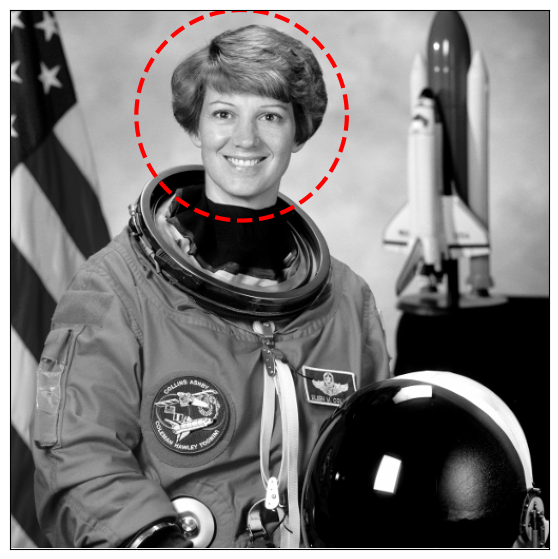

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage import data
from skimage.filters import gaussian
from skimage.segmentation import active_contour


img = data.astronaut()
img = rgb2gray(img)

s = np.linspace(0, 2*np.pi, 400)
r = 100 + 100*np.sin(s)
c = 220 + 100*np.cos(s)
init = np.array([r, c]).T
print(init[0])

# snake = active_contour(gaussian(img, 3, preserve_range=False),
#                        init, alpha=0.015, beta=10, gamma=0.001)

fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(img, cmap=plt.cm.gray)
ax.plot(init[:, 1], init[:, 0], '--r', lw=3)
# ax.plot(snake[:, 1], snake[:, 0], '-b', lw=3)
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, img.shape[1], img.shape[0], 0])

plt.show()

In [53]:
a = np.array([[1,4], [3,1]])
a.sort(axis=1)
a

array([[1, 4],
       [1, 3]])

In [23]:
x = np.zeros((snake.shape[0], snake.shape[0]))

for i, j in snake:
    i = int(i)
    j = int(j)
    x[i, j] = 1

print(np.sum(x))

161.0


In [69]:
xy_coords.sort(axis=0)
xy_coords

array([[ 90, 102],
       [ 90, 102],
       [ 90, 102],
       [ 90, 103],
       [ 90, 103],
       [ 90, 104],
       [ 90, 104],
       [ 90, 104],
       [ 90, 105],
       [ 90, 105],
       [ 90, 106],
       [ 90, 106],
       [ 90, 106],
       [ 90, 107],
       [ 90, 107],
       [ 90, 107],
       [ 90, 107],
       [ 90, 107],
       [ 90, 107],
       [ 90, 107],
       [ 91, 108],
       [ 91, 108],
       [ 91, 108],
       [ 91, 108],
       [ 91, 108],
       [ 92, 108],
       [ 92, 109],
       [ 92, 109],
       [ 92, 109],
       [ 92, 109],
       [ 93, 110],
       [ 93, 110],
       [ 93, 110],
       [ 93, 110],
       [ 93, 111],
       [ 94, 111],
       [ 94, 111],
       [ 94, 111],
       [ 94, 112],
       [ 95, 112],
       [ 95, 112],
       [ 95, 112],
       [ 96, 113],
       [ 96, 113],
       [ 96, 113],
       [ 96, 113],
       [ 96, 114],
       [ 96, 114],
       [ 96, 114],
       [ 96, 114],
       [ 96, 115],
       [ 96, 115],
       [ 96,

In [126]:
x = [1, 2, 3, 4, 5, 6]

In [127]:
print(x)

[1, 2, 3, 4, 5, 6]


In [131]:
q = np.delete(x, 3)

In [132]:
print(x)
print(q)

[1, 2, 3, 4, 5, 6]
[1 2 3 5 6]


In [165]:
# filled_snake = flood_fill(snake, (100, 100), 2)
nx, ny = mask.shape
new_mask = np.zeros((nx,ny))

for i in snake[:,0]:
    for j in snake[:,1]:
        new_mask[int(i), int(j)] = 3

new_mask = flood_fill(new_mask, (102, 116), 3)
indeces = np.where(init_3 == 3)
coords_new = np.column_stack(indeces)

In [166]:
print(np.unique(new_mask))

[0. 3.]


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [5]:
x = np.zeros(5)
x[2] = 3
print(x)
x[x == 3] = 0
print(x)

[0. 0. 3. 0. 0.]
[0. 0. 0. 0. 0.]
